In [48]:
import os
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import urllib, json, time, re

from IPython.display import display
pd.options.display.max_columns = None

In [74]:
# =====================
# 1. Setup
# =====================
# Make sure to set your X API Bearer Token in your environment before running

BEARER_TOKEN = os.getenv("X_BEARER_TOKEN")
AUTH_TOKEN = os.getenv("X_AUTH_TOKEN")
CT0_TOKEN = os.getenv("X_CT0_TOKEN")
BASE_URL = "https://x.com/i/api/graphql/7fWgap3nJOk9UpFV7UqcoQ/SearchTimeline"

if not BEARER_TOKEN:
    raise ValueError("Please set your X_BEARER_TOKEN environment variable.")

headers = {
    "Authorization": f"Bearer {BEARER_TOKEN}",
    "Content-Type": "application/json"
}

response = json.loads(requests.post("https://api.x.com/1.1/guest/activate.json", headers=headers).text)
guest_token = response['guest_token']
# print(guest_token['guest_token'])
OPERATION_HASH = "7fWgap3nJOk9UpFV7UqcoQ"  # <== replace with actual hash

hashtags = ["#BahaSaLuneta", "#TrillionPesoMarch"]
adv_search = "until:2025-09-23 since:2025-09-20"
count = 20

headers = {
    "accept": "*/*",
    "accept-language": "en-US,en;q=0.9",
    "authorization": f"Bearer {BEARER_TOKEN}",
    "cache-control": "no-cache",
    "content-type": "application/json",
    "pragma": "no-cache",
    "priority": "u=1, i",
    "referer": "https://x.com/search?q=%23BahaSaLuneta&src=typed_query&f=live",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/140.0.0.0 Safari/537.36",
    "x-client-transaction-id": "Pv/slf177gNJtRaaLUPk46pFX9Q9qnufmzHovb9VfdX5wr7G0Y1ga4B9wCG9OkEuQQZ1vTrkLwYCuKVeEwDGyfMNmMprPQ",
    "x-csrf-token": CT0_TOKEN,
    "x-twitter-active-user": "yes",
    "x-twitter-auth-type": "OAuth2Session",
    "x-twitter-client-language": "en",
    # NOTE: "x-xp-forwarded-for" looks like a signature; often optional unless enforced
}

features = {
    "rweb_video_screen_enabled": False,
    "payments_enabled": False,
    "profile_label_improvements_pcf_label_in_post_enabled": True,
    "rweb_tipjar_consumption_enabled": True,
    "verified_phone_label_enabled": False,
    "creator_subscriptions_tweet_preview_api_enabled": True,
    "responsive_web_graphql_timeline_navigation_enabled": True,
    "responsive_web_graphql_skip_user_profile_image_extensions_enabled": False,
    "premium_content_api_read_enabled": False,
    "communities_web_enable_tweet_community_results_fetch": True,
    "c9s_tweet_anatomy_moderator_badge_enabled": True,
    "responsive_web_grok_analyze_button_fetch_trends_enabled": False,
    "responsive_web_grok_analyze_post_followups_enabled": True,
    "responsive_web_jetfuel_frame": True,
    "responsive_web_grok_share_attachment_enabled": True,
    "articles_preview_enabled": True,
    "responsive_web_edit_tweet_api_enabled": True,
    "graphql_is_translatable_rweb_tweet_is_translatable_enabled": True,
    "view_counts_everywhere_api_enabled": True,
    "longform_notetweets_consumption_enabled": True,
    "responsive_web_twitter_article_tweet_consumption_enabled": True,
    "tweet_awards_web_tipping_enabled": False,
    "responsive_web_grok_show_grok_translated_post": False,
    "responsive_web_grok_analysis_button_from_backend": True,
    "creator_subscriptions_quote_tweet_preview_enabled": False,
    "freedom_of_speech_not_reach_fetch_enabled": True,
    "standardized_nudges_misinfo": True,
    "tweet_with_visibility_results_prefer_gql_limited_actions_policy_enabled": True,
    "longform_notetweets_rich_text_read_enabled": True,
    "longform_notetweets_inline_media_enabled": True,
    "responsive_web_grok_image_annotation_enabled": True,
    "responsive_web_grok_imagine_annotation_enabled": True,
    "responsive_web_grok_community_note_auto_translation_is_enabled": False,
    "responsive_web_enhance_cards_enabled": False,
}

cookies = {
    # You can paste your cookies here from the `-b` flag
    "auth_token": AUTH_TOKEN,
    "ct0": CT0_TOKEN,
    "guest_id": "v1:174772408410286939",
    "twid": "u=42900828"
    # ...
    # Add only the required ones (guest_id, ct0, auth_token, twid usually enough)
}

all_responses = []
cursor = None

for hashtag in hashtags:
    variables = {
        "rawQuery": f"{hashtag} {adv_search}",
        "count": count,
        "querySource": "typed_query",
        "product": "Top",
        "withGrokTranslatedBio": False,
    }
    
    while True:
        if cursor:
            variables["cursor"] = cursor
        
        params = {
            "variables": json.dumps(variables),
            "features": json.dumps(features),
        }
    
        params_enc = urllib.parse.urlencode(params)
        
        resp = requests.get(BASE_URL, headers=headers, params=params_enc, cookies=cookies)
        # print(resp.status_code)
        if(resp.status_code == 200):
            data = resp.json()
            all_responses.extend(data["data"]["search_by_raw_query"]["search_timeline"]["timeline"]["instructions"])
        else:
            time.sleep(10)
            continue
    
        # try extracting next cursor
        try:
            instructions = data["data"]["search_by_raw_query"]["search_timeline"]["timeline"]["instructions"]
            cursor_entries = [entry for instr in instructions for entry in instr.get("entries", []) if "cursorType" in entry.get("content", {})]
            next_cursor = None
            for entry in cursor_entries:
                if entry["content"]["cursorType"] == "Bottom":
                    next_cursor = entry["content"]["value"]
                    # print(next_cursor)
                    break
        except Exception as e:
            print("Cursor extraction failed:", e)
            break
    
        if not next_cursor:
            print(f"No more pages for {hashtag}.")
            break
    
        cursor = next_cursor

No more pages for #BahaSaLuneta.
No more pages for #TrillionPesoMarch.


In [77]:
tweets = []
for entry in all_responses:
    if "entries" in entry:
        for item in entry["entries"]:
            content = item.get("content", {})
            if "itemContent" in content:
                tweet = content["itemContent"].get("tweet_results", {}).get("result", {})
                legacy = tweet.get("legacy", {})
                if legacy:
                    tweets.append({
                        "query": re.findall(r"(#BahaSaLuneta|#TrillionPesoMarch)", legacy.get("full_text")),
                        # "text": legacy.get("full_text"),
                        "tweet_id": tweet.get("rest_id"),
                        "user": legacy.get("user_id_str"),
                        "created_at": legacy.get("created_at"),
                        "retweets": legacy.get("retweet_count"),
                        "replies": legacy.get("reply_count"),
                        "likes": legacy.get("favorite_count"),
                        "quotes": legacy.get("quote_count", 0)
                    })

# --- Convert to Pandas DataFrame ---
df = pd.DataFrame(tweets)
# print(df)

In [78]:
display(df)

,query,tweet_id,user,created_at,retweets,replies,likes,quotes
0,[#BahaSaLuneta],1969617128417607906,1238313560163393536,Sun Sep 21 04:18:11 +0000 2025,42438,27,82309,738
1,"[#BahaSaLuneta, #TrillionPesoMarch]",1969611202985935147,1875571406676881410,Sun Sep 21 03:54:39 +0000 2025,83304,109,162918,1252
2,"[#BahaSaLuneta, #TrillionPesoMarch]",1969573728322535680,1943666978620915713,Sun Sep 21 01:25:44 +0000 2025,57520,52,101913,817
3,"[#BahaSaLuneta, #TrillionPesoMarch]",1969707148579098901,1816070678241775616,Sun Sep 21 10:15:54 +0000 2025,16242,38,46980,416
4,[#BahaSaLuneta],1969578926138896420,148298090,Sun Sep 21 01:46:23 +0000 2025,38931,43,88626,828
5,[#BahaSaLuneta],1969729515900612681,1342438095086526464,Sun Sep 21 11:44:47 +0000 2025,4865,9,12251,42
6,[#BahaSaLuneta],1969580992320192633,1745628507101937664,Sun Sep 21 01:54:36 +0000 2025,14703,23,65197,265
7,"[#BahaSaLuneta, #TrillionPesoMarch]",1969626817620558097,1464218362775760896,Sun Sep 21 04:56:41 +0000 2025,30871,11,61681,334
8,[#BahaSaLuneta],1969559556247470155,1959467368113131520,Sun Sep 21 00:29:25 +0000 2025,23757,52,68791,391
9,"[#TrillionPesoMarch, #BahaSaLuneta]",1969563842608054543,1008301994,Sun Sep 21 00:46:27 +0000 2025,14399,46,44285,236


In [79]:
# Explode data to get one row per hashtag
df = df.explode('query') \
    .reset_index(drop=True)    # reset index to reset numbering

display(df)

,query,tweet_id,user,created_at,retweets,replies,likes,quotes
0,#BahaSaLuneta,1969617128417607906,1238313560163393536,Sun Sep 21 04:18:11 +0000 2025,42438,27,82309,738
1,#BahaSaLuneta,1969611202985935147,1875571406676881410,Sun Sep 21 03:54:39 +0000 2025,83304,109,162918,1252
2,#TrillionPesoMarch,1969611202985935147,1875571406676881410,Sun Sep 21 03:54:39 +0000 2025,83304,109,162918,1252
3,#BahaSaLuneta,1969573728322535680,1943666978620915713,Sun Sep 21 01:25:44 +0000 2025,57520,52,101913,817
4,#TrillionPesoMarch,1969573728322535680,1943666978620915713,Sun Sep 21 01:25:44 +0000 2025,57520,52,101913,817
...,...,...,...,...,...,...,...,...
71,#TrillionPesoMarch,1969593177972854797,1813608582019211264,Sun Sep 21 02:43:01 +0000 2025,17876,34,34418,608
72,#BahaSaLuneta,1969593177972854797,1813608582019211264,Sun Sep 21 02:43:01 +0000 2025,17876,34,34418,608
73,#TrillionPesoMarch,1969500223778275602,1306230642204504064,Sat Sep 20 20:33:39 +0000 2025,36495,52,62232,1289
74,#BahaSaLuneta,1969500223778275602,1306230642204504064,Sat Sep 20 20:33:39 +0000 2025,36495,52,62232,1289


In [ ]:
# =====================
# 2. Fetch Data from X API
# =====================
def fetch_hashtag_data(hashtag, max_results=50):
    url = "https://api.x.com/2/tweets/search/recent"
    params = {
        "query": hashtag,
        "max_results": max_results,
        "tweet.fields": "author_id,created_at,public_metrics"
    }
    r = requests.get(url, headers=headers, params=params)
    r.raise_for_status()
    return r.json()

hashtags = ["#BahaSaLuneta"]
frames = []
for tag in hashtags:
    data = fetch_hashtag_data(tag)
    df_temp = pd.DataFrame(data.get("data", []))
    if not df_temp.empty:
        df_temp["hashtag"] = tag
        frames.append(df_temp)

if not frames:
    raise ValueError("No data retrieved from X API. Check hashtags or API permissions.")

df = pd.concat(frames, ignore_index=True)

In [83]:
# =====================
# 3. Wrangle Engagement Data
# =====================
# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], format="%a %b %d %H:%M:%S %z %Y")

# Create a created_date field
df['created_date'] = df['created_at'].dt.date

display(df)

,query,tweet_id,user,created_at,retweets,replies,likes,quotes,created_date,engagement
0,#BahaSaLuneta,1969617128417607906,1238313560163393536,2025-09-21 04:18:11+00:00,42438,27,82309,738,2025-09-21,125512
1,#BahaSaLuneta,1969611202985935147,1875571406676881410,2025-09-21 03:54:39+00:00,83304,109,162918,1252,2025-09-21,247583
2,#TrillionPesoMarch,1969611202985935147,1875571406676881410,2025-09-21 03:54:39+00:00,83304,109,162918,1252,2025-09-21,247583
3,#BahaSaLuneta,1969573728322535680,1943666978620915713,2025-09-21 01:25:44+00:00,57520,52,101913,817,2025-09-21,160302
4,#TrillionPesoMarch,1969573728322535680,1943666978620915713,2025-09-21 01:25:44+00:00,57520,52,101913,817,2025-09-21,160302
...,...,...,...,...,...,...,...,...,...,...
71,#TrillionPesoMarch,1969593177972854797,1813608582019211264,2025-09-21 02:43:01+00:00,17876,34,34418,608,2025-09-21,52936
72,#BahaSaLuneta,1969593177972854797,1813608582019211264,2025-09-21 02:43:01+00:00,17876,34,34418,608,2025-09-21,52936
73,#TrillionPesoMarch,1969500223778275602,1306230642204504064,2025-09-20 20:33:39+00:00,36495,52,62232,1289,2025-09-20,100068
74,#BahaSaLuneta,1969500223778275602,1306230642204504064,2025-09-20 20:33:39+00:00,36495,52,62232,1289,2025-09-20,100068


In [86]:
# Engagement = likes + retweets + replies + quotes
df["engagement"] = df["likes"] + df["retweets"] + df["replies"] + df["quotes"]

print("Average engagement per hashtag per date:")
display(df.groupby(["query", "created_date"])["engagement"].mean())

Average engagement per hashtag per date:


query               created_date
#BahaSaLuneta       2025-09-20      69912.500000
                    2025-09-21      53375.756757
                    2025-09-22      11774.000000
#TrillionPesoMarch  2025-09-20      67607.750000
                    2025-09-21      51692.916667
                    2025-09-22       7457.250000
Name: engagement, dtype: float64

In [87]:
# =====================
# 4. SQL Queries
# =====================
conn = sqlite3.connect(":memory:")
df.to_sql("tweets", conn, index=False, if_exists="replace")

query = """
SELECT query,
       created_date,
       COUNT(*) as num_posts,
       AVG(engagement) as avg_engagement
FROM tweets
GROUP BY query, created_date
ORDER BY num_posts DESC
"""

# Create a new df from sqlite query
sql_df = pd.read_sql_query(query, conn)
print("\nSQL Aggregation Result:")
print(sql_df)


SQL Aggregation Result:
                query created_date  num_posts  avg_engagement
0       #BahaSaLuneta   2025-09-21         37    53375.756757
1  #TrillionPesoMarch   2025-09-21         24    51692.916667
2       #BahaSaLuneta   2025-09-20          4    69912.500000
3  #TrillionPesoMarch   2025-09-20          4    67607.750000
4  #TrillionPesoMarch   2025-09-22          4     7457.250000
5       #BahaSaLuneta   2025-09-22          3    11774.000000


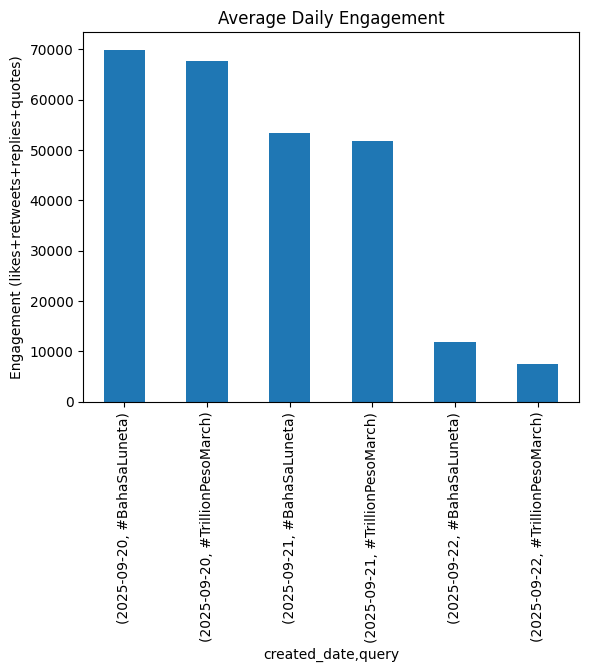

In [106]:
# =====================
# 5. Visualization
# =====================
avg_engagement = df.groupby(["created_date", "query"])["engagement"].mean()
avg_engagement.plot(kind="bar", title=f"Average Daily Engagement", rot=0)
plt.xticks(rotation=90)
plt.ylabel("Engagement (likes+retweets+replies+quotes)")
plt.show()

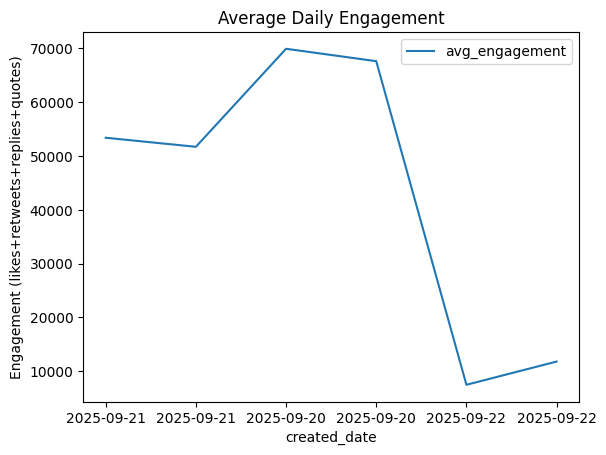

In [105]:
# Do for the sql_df
sql_df.plot(kind="line", x='created_date', y='avg_engagement', title=f"Average Daily Engagement", rot=0)
plt.ylabel("Engagement (likes+retweets+replies+quotes)")
plt.show()

<Axes: xlabel='created_date'>

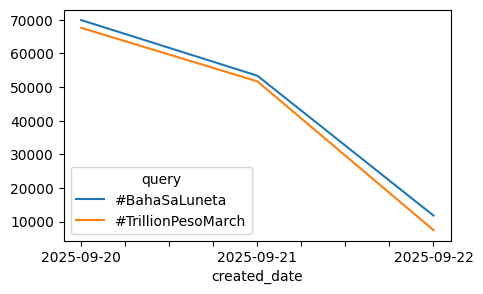

In [104]:
sql_df_pvt = sql_df.pivot(index='created_date', columns='query', values='avg_engagement')
sql_df_pvt.plot(kind="line", figsize=(5,3))